In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from scipy import stats
import math
from scipy.sparse import csc_matrix
import random
import operator
import scipy.io
import collections
import heapq

import csv
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from math import log
from scipy import stats
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = 4, 4
subSize=10000

In [2]:
Data = open('edges.csv', "r")
Graphtype = nx.Graph()

G = nx.parse_edgelist(Data, comments='t', delimiter=',', create_using=Graphtype,
                      nodetype=int, data=(('weight', float),))

In [3]:
# Take subgraph for less computations
# sub_edges=random.sample(list(diG.edges()),subSize) <-- wrong as it definitely loses properties of original graph
# G=nx.Graph(sub_edges)
G.remove_edges_from(G.selfloop_edges())


# the one-fold of YES edges
total_edges=list(G.edges())
np.random.shuffle(total_edges)
l=int(len(total_edges)*0.7) # keep 70% graph, 30% for growth labels
# edges_0 exist only for common neighbors
edges_0,ETEs = total_edges[:l], total_edges[l:]

"""
 Use all the edges present in the network as "YES", and randomly choose equal number of "Non-existing" edges as "NO". 
"""
# Randomly choose equal sized (entire)fold of NO edges
nonETEs=random.sample(list(nx.non_edges(G)),len(ETEs))
total_edges=ETEs+nonETEs #total in consideration

xe,nxe=len(ETEs),len(nonETEs)
methods=['CN','JC','AA','RA','PA']

## 
## NOTE: HAVENT CHECKED FOR CONNECTIVITY MAINTAINED.
# len(nx.bfs_tree(G,nodelist[0]).edges())
# # extract matrix in order, and convert to dense representation
# A = nx.adjacency_matrix(G, nodelist=nodelist).todense()
N=G.number_of_nodes()
# store index for node index
nodelist = list(G.nodes())

In [4]:
print(nx.info(G))
print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))
print(nx.is_directed(G))

Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 333983
Average degree:  64.7756
10312
333983
False


In [5]:
def nonedges(G,u):  #a generator with (u,v) for every non neighbor v
    for v in nx.non_neighbors(G, u):
        yield (u, v)

In [6]:
for u in G.nodes():
    adar = nx.adamic_adar_index(G,nonedges(G,u))
    for v in nx.non_neighbors(G, u):
        com = nx.common_neighbors(G,u,v)
    jac = nx.jaccard_coefficient(G,nonedges(G,u))
    res = nx.resource_allocation_index(G,nonedges(G,u))
    pre = nx.preferential_attachment(G,nonedges(G,u))
#     tenlargest = heapq.nlargest(10, pred, key = lambda x: x[2])
#     print(tenlargest)
#     for u,v,p in pred:
#         print(u,v,p)

In [7]:
allm={m:{} for m in methods}
toponame="dataset"+".csv"
with open(toponame,"w",newline="", encoding="utf-8") as f:   # binary mode for windows \r\n prob
    writer = csv.writer(f, delimiter=',')        
    writer.writerow(['node1','node2']+methods+['label'])

#     for i,n1 in enumerate(nodelist):
#         for j,n2 in enumerate(nodelist):
#             if(i==j):
#                 continue
    for p in total_edges:
            n1,n2=p
            ngh1 = set(G[n1])
            ngh2 = set(G[n2])
            inter = ngh1.intersection(ngh2) # ngh1 & ngh2
            inter_l = len(inter)
            union_l = len(ngh1.union(ngh2)) #ngh1 | ngh2            
            
            allm['CN'][p]=inter_l
            allm['JC'][p]=(inter_l/union_l) if union_l else 0.0
            allm['AA'][p]=sum([1/log(len(G[z])) for z in inter]) # denom cant be zero as atleast 2 edges
            allm['RA'][p]=sum([1/len(G[z]) for z in inter])
            allm['PA'][p]=len(ngh1)*len(ngh2)
            
            # + can add your own features
            writer.writerow(list(p) + [allm[m][p] for m in methods] + [1 if G.has_edge(n1,n2) else 0])

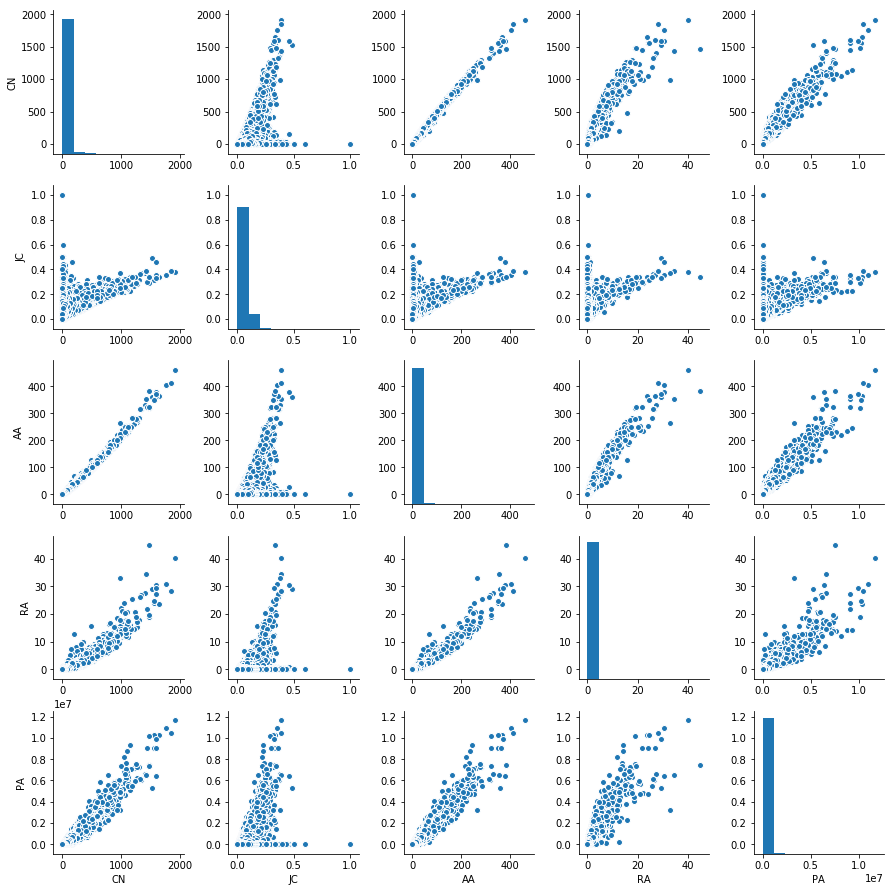

In [8]:
# library & dataset
import seaborn as sns

import pandas as pd
df=pd.read_csv(toponame)
df=df[methods]
# df.describe()
# Basic correlogram
sns.pairplot(df)
plt.show()

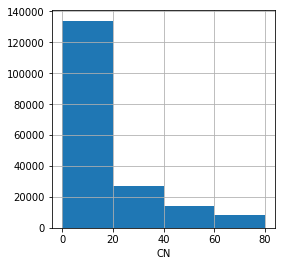

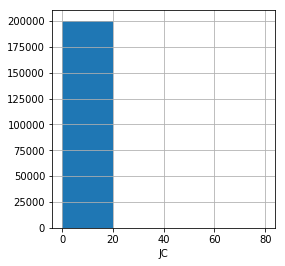

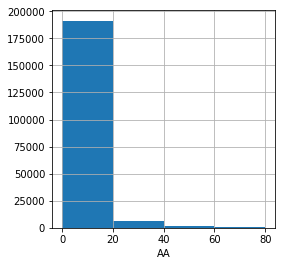

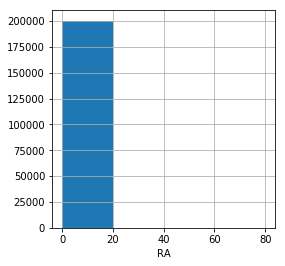

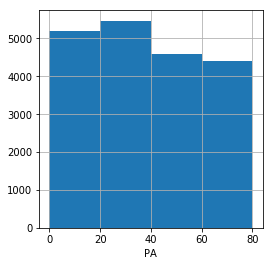

In [9]:
for m in methods:
    plt.subplots()
    plt.xlabel(m)
    df[m].hist(align='mid',bins=[0,20,40,60,80,])#plot(kind='kde')
    


          CN        JC        AA        RA        PA
CN  1.000000  0.543185  0.993342  0.872918  0.935820
JC  0.543185  1.000000  0.507857  0.367063  0.356828
AA  0.993342  0.507857  1.000000  0.921550  0.954994
RA  0.872918  0.367063  0.921550  1.000000  0.910446
PA  0.935820  0.356828  0.954994  0.910446  1.000000


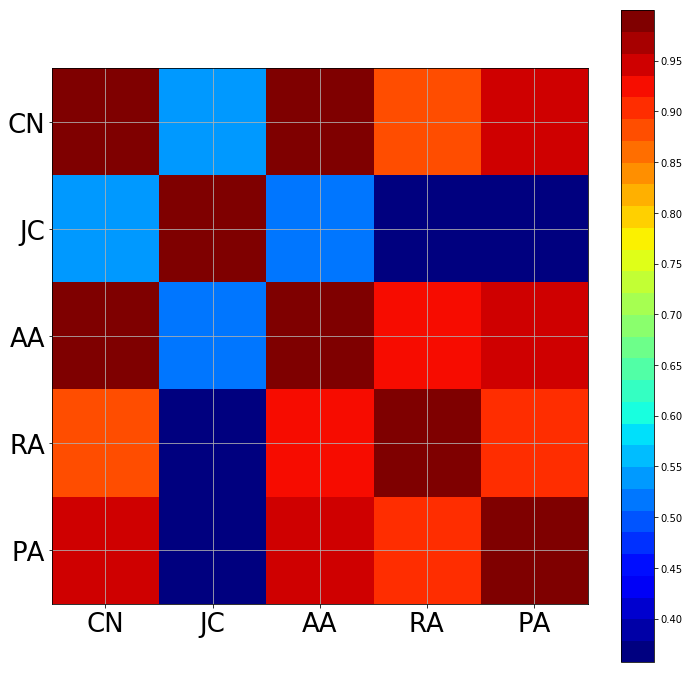

In [10]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(axis='both')
    labels=['X']+methods
    ax1.set_xticklabels(labels,fontsize=26)
    ax1.set_yticklabels(labels,fontsize=26)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=list([x/100 for x in range(0,100,5)]))
    plt.show()

print(df.corr())
correlation_matrix(df)

In [11]:
#precision and recall for topological algorithms#
def precision_recall(score_labels, k):
    l=len(score_labels)
    thresh = score_labels[int(l*k)][0]           #all above threshold will have greater cn/jj/aa value. so, label should be 1
    truepos = 0
    falsepos = 0
    falseneg=0
    trueneg =0
    for i in range(0, l):
        if(score_labels[i][1]==1 and score_labels[i][0]>=thresh):
            truepos+=1
        elif (score_labels[i][1]==0 and score_labels[i][0]>=thresh):
            falsepos+=1
        if(score_labels[i][1]==0 and score_labels[i][0]<=thresh):
            trueneg+=1
        elif(score_labels[i][1]==1 and score_labels[i][0]<=thresh):
            falseneg+=1
    
    truepos = float(truepos)
    trueneg = float(trueneg)
    falsepos = float(falsepos)
    falseneg = float(falseneg)
    p = '%.3f'%float(truepos/(truepos+falsepos))
    r = '%.3f'%float(truepos/(truepos+falseneg))
    return [p,r]

all_edges_score,nonExisting={},{}
for m in methods:
    nonExisting[m] = sorted([(e,allm[m][e]) for e in nonETEs],key=lambda x:x[1])
    all_edges_score[m] = sorted([(allm[m][e],1) for e in ETEs]+[(allm[m][e],0) for e in nonETEs],key=lambda x:x[0],reverse=True)


In [ ]:
all_edges_score['CN'][:10]

[(1913, 1),
 (1848, 1),
 (1761, 1),
 (1649, 1),
 (1600, 1),
 (1594, 1),
 (1592, 1),
 (1564, 1),
 (1555, 1),
 (1526, 1)]

In [ ]:
""" 
For AUC: 
for two node pairs p1,p2 
AUC = P( p1.score > p2.score and p1 is existing and p2 is non-existing )
above value is averaged over all node pairs
"""
# for name,edges in zip(["metrics_for_existing"+".csv","metrics_for_nonexisting"+".csv"],[edgelist,nonedgelist]):
topoaucname="topological_metrics"+".csv"
"""
AvgAUC =(n1 + 0.5n2)/n ∗ p
where 
n1 = number of times link prediction score for existing test edge is greater than other non-existing test edges, 
n2 = number of times link prediction score for existing test edge is equal to other non-existing test edges,
n = number of non-existing test edges, and p = number of existing test edges.
"""
# Source for formula: https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxha2FzaGFuaWwyNjAxfGd4OjI5Y2ExYmExMGI0OWE0ODc
with open(topoaucname,"w",newline="", encoding="utf-8") as f:   # binary mode for windows \r\n prob
    writer = csv.writer(f, delimiter=',')        
    writer.writerow(['node1','node2']+methods)
    sumAUC={m:0 for m in methods}
    total={m:0 for m in methods}
    for p in ETEs:
        row=[p[0],p[1]]
        
        for m in methods:        
            score=allm[m][p]
            count=0.0
            for s in nonExisting[m]:
                if(s[1]<score):
                    count+=1.0
                elif(s[1]==score):
                    count+=0.5
                else:
                    break
            local_auc = count/nxe
            sumAUC[m]+=local_auc            
            total[m]+=1
            row.append(local_auc)
            
        writer.writerow(row)
    row=['overall AUC','-']
    row2=['PR@25%','-']
    row3=['PR@50%','-']
    row4=['PR@75%','-']
    for m in methods:
        assert(total[m]==xe)
        row.append(sumAUC[m]/xe) # avg 
        row2.append(precision_recall(all_edges_score[m],k=0.25))
        row3.append(precision_recall(all_edges_score[m],k=0.50))
        row4.append(precision_recall(all_edges_score[m],k=0.75))
    print(row)
    writer.writerow(row)
    print(row2)
    writer.writerow(row2)
    print(row3)
    writer.writerow(row3)
    print(row4)
    writer.writerow(row4)

#  If time: do Precision@K
#
#

In [ ]:
methods

In [ ]:
df = np.genfromtxt(toponame, delimiter=',',skip_header=1)

for m in range(2,2+len(methods)):
    print(m,df[2:,m].max())
    df[2:,m] = df[2:,m] / df[2:,m].max()
x=df[:,2:-1]
y=df[:,-1]
y

In [ ]:
import math
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

def reportClassifier(name,y_test,y_pred,scores=None):
    print("\n\t\t"+name)
    if(scores is not None):
        print("\nCross Validation Scores")
        print(scores)
    print("\nAccuracy: ",accuracy_score(y_test,y_pred))
    print("\nClassification Report")
    print(classification_report(y_test,y_pred))    
    print("\nConfusion Matrix")
    print(confusion_matrix(y_test,y_pred))
    try:
        print("\nROC AUC score")
        print(roc_auc_score(y_test, y_pred))
    except ValueError:
        print("Warning: Only one class in this fold")

def mean(x):
    return sum(x)/float(len(x))
 
def stddev(x):
    if(len(x)<2):
        return -1;
    avg = mean(x)
    variance = sum([pow(x-avg,2) for x in x])/float(len(x)-1)
    return math.sqrt(variance)

def getFeatureProbability(x, mean, stddev):
    if(stddev==0):# spike in gaussian
        return 1 if x==mean else 0
    exp = math.exp(-1*( math.pow(x-mean,2) / (2*math.pow(stddev,2))))
    return (1 / (math.sqrt(2*math.pi) * stddev)) * exp

def splitByLabel(x,y):
    yes,no=[],[]
    for i in range(len(y)):
        if(y[i]):
            yes.append(x[i,:])
        else:
            no.append(x[i,:])
    return yes,no

def getMeanStds(x_train):
    mean_stds=[]
    for i in range(len(x_train[0])): # 5 times
        mean_stds.append((mean(x_train[i]),stddev(x_train[i])))
    return mean_stds


def naive_bayes_gaussian(x_train,y_train):    
    h,w=x_train.shape
    labelYes,labelNo= splitByLabel(x_train,y_train)
    # Train part:
    yes_mean_stds=getMeanStds(labelYes)
    no_mean_stds=getMeanStds(labelNo)
    return yes_mean_stds,no_mean_stds

def predict_naive_bayes(x_test,yms,nms):    
    h,w=x_test.shape
    y_pred=[]
    #     p(Ci)
    p=len(yms)/(len(yms)+len(nms))
    # test part
    for i in range(h):
        x=x_test[i]
        p_yes,p_no=p,1-p
        for j in range(w): # 5 times
            m,s=yms[j]
            nm,ns=nms[j]
            p_yes *= getFeatureProbability(x[j],m,s)
            p_no *= getFeatureProbability(x[j],nm,ns)
        if(p_yes>=p_no):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [ ]:
                

# For classifers: make five-folds
# foldSize=xe//5
# edge_folds = [ETEs[i*foldSize:(i+1)*foldSize] if i<4 else ETEs[i*foldSize:] for i in range(0,5)]
# nonedge_folds = [ETEs[i*foldSize:(i+1)*foldSize] if i<4 else ETEs[i*foldSize:] for i in range(0,5)]

kf=KFold(n_splits=5,shuffle=True)
# for i in range(0,5):
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    yes_mean_stds,no_mean_stds = naive_bayes_gaussian(x_train,y_train)
    y_pred = predict_naive_bayes(x_test,yes_mean_stds,no_mean_stds)
    reportClassifier("GaussianUD",y_test,y_pred)

    #for trial-
    b=GaussianNB()
    b.fit(x_train,y_train)
    y_pred=b.predict(x_test)
    reportClassifier("GaussianNB",y_test,y_pred)
    
#     b=MultinomialNB()
#     b.fit(x_train,y_train)
#     y_pred=b.predict(x_test)
#     reportClassifier("MultinomialNB",y_test,y_pred)
    
#     b=BernoulliNB(binarize=True)
#     b.fit(x_train,y_train)
#     y_pred=b.predict(x_test)
#     reportClassifier("BernoulliNB",y_test,y_pred)
        

In [ ]:
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(x_train, y_train)
    scores = cross_val_score(svclassifier,x, y, cv=5)
    y_pred = svclassifier.predict(x_test)
    reportClassifier("SVM",y_test,y_pred,scores)

In [ ]:
    clf = tree.DecisionTreeClassifier()
    scores = cross_val_score(clf,x, y, cv=5)
    clf = clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    reportClassifier("Decision Tree",y_test,y_pred,scores)